<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preparing the environment

## Graphics and plotting

In [38]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# general graphics settings
matplotlib.rcParams['figure.figsize'] = (10, 7)

In [39]:
import seaborn as sea

## SQL database connection

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code:

In [3]:
%load_ext sql

* Connect to an actual database; this must be the first `%sql` statement!

In [4]:
%sql postgresql://rmurri@/s_cerevisiae

u'Connected: rmurri@s_cerevisiae'

# Exploration of the Interactome *S. Cerevisiae* data set

The `y2h_union` table lists interacting proteins (by name); a pair *(proteinA, proteinB)* appears in the table if *proteinA* interacts with *proteinB*.  Note that the "interacts with" relation need not be symmetric!

This describes a *directed* graph, where the proteins are the vertices and each interaction defines an edge.

Let us have a look at the `y2h_union` table:

In [7]:
%sql select * from y2h_union limit 3;

3 rows affected.


symbol_a,symbol_b
Q0085,YCR106W
TORF1,YCR106W
TORF19,YDR361C


Alternatively, one can load the data from the `Y2H_union.tsv` file using only Python functions:

In [5]:
data = []
with open('Y2H_union.tsv', 'r') as stream:
    for line in stream:
        data.append(line.split())

In [6]:
data[:3]

[['MEL1', 'YJL092W'], ['Q0085', 'YCR106W'], ['TORF1', 'YCR106W']]

----

*Each of the following questions admit a solution using an algorithm in Python, or just an SQL query.*

Use whichever suits you best.

## How can you compute the "in-degree" of a given vertex?

The *in-degree* is the number of *incoming* vertices, so it would be the number of distinct pairs *(A,B)* with *B* equal to the given vertex:

In [7]:
%%time

%sql SELECT COUNT(DISTINCT symbol_a) FROM y2h_union WHERE symbol_b = 'YCR106W';

1 rows affected.
CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 2.98 ms


count
4


Again we can dispense of the `DISTINCT` keyword since we know that the data contains no duplicates by construction:

In [8]:
%%time

%sql SELECT COUNT(symbol_a) FROM y2h_union WHERE symbol_b = 'YCR106W';

1 rows affected.
CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 2.11 ms


count
4


In [40]:
%%time

%sql SELECT 1;

1 rows affected.
CPU times: user 1.49 ms, sys: 0 ns, total: 1.49 ms
Wall time: 1.62 ms


?column?
1


We can do the same in Python by looping over the list and counting the number of items in which the given protein appears in the second place:

In [9]:
def in_degree(p):
    count = 0
    for a, b in data:
        if b == p:
            count += 1
            
    return count

In [10]:
%%time

in_degree('YCR106W')

CPU times: user 374 µs, sys: 55 µs, total: 429 µs
Wall time: 433 µs


4

## How can you compute the "out-degree" of a given vertex?

This is the same query as above, with *A* and *B* swapped:

In [15]:
%sql SELECT COUNT(DISTINCT symbol_b) FROM y2h_union WHERE symbol_a = 'YCR106W';

1 rows affected.


count
16


Same for Python:

In [14]:
def out_degree(p):
    count = 0
    for a, b in data:
        if a == p:
            count += 1
            
    return count

In [16]:
out_degree('YCR106W')

16

## How can you compute the degree (i.e., regardless of direction) of a given vertex?

The degree is the number of edges incident at a vertex, regarless of direction.

In query terms, this means we want `symbol_a` when `symbol_b` is the given protein name, *or* `symbol_b` when `symbol_a` is the given.

We cannot however change the columns requested in the SELECT clause depending on a predicate: the above line translates rather to *two* distinct queries.

Standard SQL however provides the [UNION][1] operator to aggregate results from two distinct queries:

[1]: http://www.tutorialspoint.com/sql/sql-unions-clause.htm

In [18]:
%%sql

SELECT symbol_a AS protein FROM y2h_union WHERE symbol_b = 'YCR106W'

UNION 

SELECT symbol_b AS protein FROM y2h_union WHERE symbol_a = 'YCR106W' 

LIMIT 5;

5 rows affected.


protein
YHR130C
YJL006C
YGR140W
YPL034W
YPL267W


Now we can just wrap this into an outer SELECT COUNT() query:

In [23]:
%%sql

WITH total AS (
  SELECT symbol_a AS protein FROM y2h_union WHERE symbol_b = 'YCR106W'
  UNION 
  SELECT symbol_b AS protein FROM y2h_union WHERE symbol_a = 'YCR106W' 
)
SELECT COUNT(DISTINCT protein) FROM total;

1 rows affected.


count
20


A simpler way is to use Python and just observe that the (total) degree is just the sum of in- and out-degree:

In [17]:
def degree(v):
    return in_degree(v) + out_degree(v)

In [18]:
degree('YCR106W')

20

## How can you compute the vertex degree distribution?

Computing the out-degree (resp. in-degree) for all proteins in one go is easy: just aggregate on the source (resp. destination) protein name:

In [25]:
%%sql 
SELECT symbol_a, COUNT(symbol_b) AS deg FROM y2h_union 
GROUP BY symbol_a 
ORDER BY deg DESC
LIMIT 5;

5 rows affected.


symbol_a,deg
YBR261C,38
YLR291C,36
YDR510W,31
YDR479C,29
YDL100C,28


To compute the value *distribution*, we need to further aggregate on the degree and count the number of elements with a given degree:

In [26]:
%%sql
WITH degrees AS (
  SELECT symbol_a, COUNT(symbol_b) AS deg FROM y2h_union 
  GROUP BY symbol_a 
  ORDER BY deg DESC
)
SELECT deg, COUNT(deg) AS freq FROM degrees
GROUP BY deg
ORDER BY freq DESC
LIMIT 5;

5 rows affected.


deg,freq
1,789
2,246
3,126
4,68
5,32


The `%sql` magic makes it simple to import these data into Python and plot it:

In [19]:
%%time

plot_data = %sql WITH degrees AS (SELECT symbol_a, COUNT(symbol_b) AS deg FROM y2h_union GROUP BY symbol_a ORDER BY deg DESC) SELECT deg, COUNT(deg) AS freq FROM degrees GROUP BY deg ORDER BY freq DESC;

26 rows affected.
CPU times: user 9.62 ms, sys: 0 ns, total: 9.62 ms
Wall time: 12.6 ms


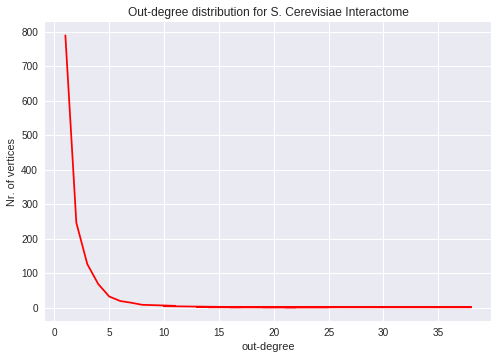

In [20]:
# convert from list of pairs to pair of lists
xs, ys = zip(* plot_data)

# plot it
plt.figure()
plt.plot(xs, ys, 'r')
plt.xlabel('out-degree')
plt.ylabel('Nr. of vertices')
plt.title('Out-degree distribution for S. Cerevisiae Interactome')

/opt/Anaconda2-4.3.0-Linux-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


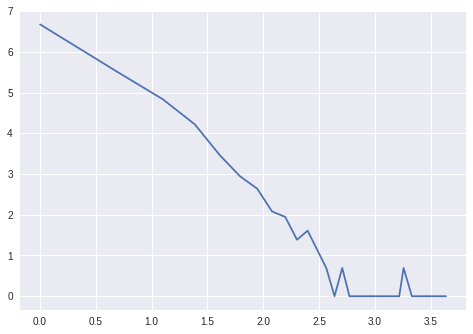

In [32]:
import numpy as np

log_xs = np.log(np.array(xs))
log_ys = np.log(np.array(ys))

plt.plot(log_xs, log_ys)

In Python this starts to take a bit longer:

*1)* Take the set of *all* vertices:

In [21]:
%%time

left_vertices = [a for a,b in data]
right_vertices = [b for a,b in data]
vertices = set(left_vertices + right_vertices)

CPU times: user 2.05 ms, sys: 0 ns, total: 2.05 ms
Wall time: 1.8 ms


*2)* Compute the out-degree of each vertex:

In [25]:
%%time

out_degrees = []
for v in vertices:
    out_degrees.append(out_degree(v))

CPU times: user 443 ms, sys: 257 µs, total: 444 ms
Wall time: 444 ms


Now compute the distribution of the `out_degrees` series:

In [26]:
%%time

counts = {}
for deg in out_degrees:
    if deg in counts:
        counts[deg] += 1
    else:
        counts[deg] = 1

CPU times: user 443 µs, sys: 31 µs, total: 474 µs
Wall time: 477 µs


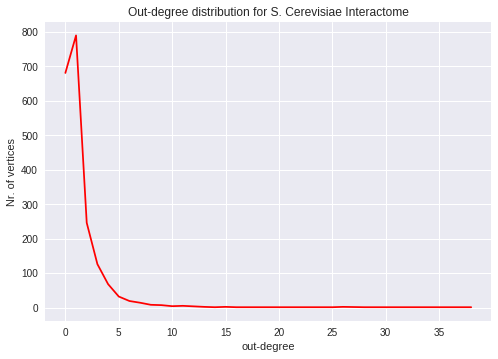

In [27]:
# convert from list of pairs to pair of lists
xs = list(counts.keys())
ys = list(counts.values())

# plot it
plt.figure()
plt.plot(xs, ys, 'r')
plt.xlabel('out-degree')
plt.ylabel('Nr. of vertices')
plt.title('Out-degree distribution for S. Cerevisiae Interactome')